In [1]:
import os
import math
import random
from typing import Dict, Literal, List, Set, Tuple, Iterable

import numpy as np
import pandas as pd
import networkx as nx
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection
import matplotlib.pyplot as plt

files = os.listdir('DataSujetos/')

In [2]:
ESTADIOS = ['W', 'N1', 'N2', 'N3']
NUM_SUJETOS = 18
ADJ_MATRIX_SIZE = 116
GLOBAL_SEED = 158151
PC = 0.05
ZC = 1

In [3]:
class Experiment():
    
    def __init__(self, density: float):
        self.density = density
        self._data = {
            estadio: {
                f'suj{i+1}': {
                    'zi': np.zeros(ADJ_MATRIX_SIZE),
                    'Pi': np.zeros(ADJ_MATRIX_SIZE),
                } for i in range(NUM_SUJETOS)
            } for estadio in ESTADIOS
         }
        
    def set_experiment_data(self, 
                            data: Dict[str, Iterable[float]], 
                            estadio: Literal['W', 'N1', 'N2', 'N3'], 
                            sujeto: str) -> None:
        self._data[estadio][sujeto] = data
            
    def get_node_classification_data_by_estadio(self, 
                                                estadio: Literal['W', 'N1', 'N2', 'N3']
                                               ) -> Dict[str, Dict[str, int]]:
        relevant_data = self._data[estadio]
        ans = {}
        for sujeto, raw_data in relevant_data.items():
            zi_mask = raw_data['zi'] > ZC
            Pi_mask = raw_data['Pi'] > PC
            num_Provincial_Hubs = np.sum(zi_mask & ~Pi_mask)
            num_Hubs = np.sum(zi_mask & Pi_mask)
            num_Connector_Nodes = np.sum(~zi_mask & Pi_mask)
            num_Provincial_Nodes = np.sum(~zi_mask & ~Pi_mask)
            ans[sujeto] = {
                'Provincial_Hubs': num_Provincial_Hubs,
                'Hubs': num_Hubs,
                'Connector_Nodes': num_Connector_Nodes,
                'Provincial_Nodes': num_Provincial_Nodes,
            }
        return ans

In [4]:
def find_threshold(adj_matrix: np.ndarray, density: float, epsilon: int=2) -> float:
    size = adj_matrix.shape
    N = size[0]*size[1]
    left = adj_matrix.min()
    right = adj_matrix.max()
    target = math.ceil(N*density)
    res = N
    cnt = 0
    limit = 100
    while res!=target:
        cnt+=1
        if cnt == limit:
            print(f'Have not converged in {limit} iterations, returning suboptimal threshold')
            return guess
        guess = (left+right)/2
        res = np.sum(adj_matrix>=guess)
        if (res>=target-epsilon) and (res<=target+epsilon):
            return guess
        elif res<target:
            right = guess
        else:
            left = guess

            
def extract_sujeto(filename: str) -> str:
    return filename.split('.')[0].split('_')[1]


def _compute_zi(G: nx.Graph) -> Dict[int, float]:
    degrees = G.degree()
    k_mean = np.mean([degree for node, degree in degrees])
    k_std = np.std([degree for node, degree in degrees])
    return {node: (degree-k_mean)/k_std for node, degree in degrees}


def _compute_Pi(G: nx.Graph, comms: List[Set[int]]) -> Dict[int, float]:
    # We start with the initial value of 1 and iteratively subtract from it according to the definition
    Pi = {node: 1 for node in range(ADJ_MATRIX_SIZE)}
    degrees = G.degree()
    for node in Pi:
        ki = degrees[node]
        neighbors = set(nx.all_neighbors(G, node))
        for C in comms:
            kiUj = len(neighbors.intersection(C))
            tmp = (kiUj/ki)**2 if ki>0 else 0
            Pi[node] -= tmp
    return Pi


def run_node_experiment(G: nx.Graph) -> Dict[str, Dict[int, float]]:
    comms = nx.community.louvain_communities(G, seed=GLOBAL_SEED)
    zi = _compute_zi(G)
    zi_values = np.array([x for x in zi.values()])
    Pi = _compute_Pi(G, comms)
    Pi_values = np.array([x for x in Pi.values()])
    return {'zi': zi_values, 'Pi': Pi_values}
    
    
def graph_factory(adjmat: np.ndarray, density: float) -> nx.Graph:
    adjmat -= np.diag(np.diag(adjmat))
    thr = find_threshold(adjmat, density)
    adjmat = adjmat>=thr
    G = nx.from_numpy_array(adjmat)
    return G

In [5]:
%%time

densities = np.linspace(0.01, 0.15, num=15)
experiments = [Experiment(d) for d in densities]
avg_graphs = []
running_avg_graph = {
    estadio: np.zeros((ADJ_MATRIX_SIZE, ADJ_MATRIX_SIZE)) for estadio in ESTADIOS
}

for i, d in enumerate(densities):
    print(f'Start with density {d}')
    exp = experiments[i]
    for estadio in ESTADIOS:
        for f in files:
            if not f.startswith(estadio):
                continue
            sujeto = extract_sujeto(f)
            adjmat = pd.read_csv('DataSujetos/'+f, header=None).values
            running_avg_graph[estadio] += adjmat/NUM_SUJETOS
            G = graph_factory(adjmat, d)
            node_data = run_node_experiment(G)
            exp.set_experiment_data(node_data, estadio, sujeto)
    avg_graphs.append(running_avg_graph)
    running_avg_graph = {
        estadio: np.zeros((ADJ_MATRIX_SIZE, ADJ_MATRIX_SIZE)) for estadio in ESTADIOS
    }

Start with density 0.01
Start with density 0.019999999999999997
Start with density 0.03
Start with density 0.039999999999999994
Start with density 0.049999999999999996
Have not converged in 100 iterations, returning suboptimal threshold
Start with density 0.05999999999999999
Start with density 0.06999999999999999
Start with density 0.07999999999999999
Start with density 0.08999999999999998
Start with density 0.09999999999999998
Start with density 0.10999999999999997
Start with density 0.11999999999999998
Start with density 0.12999999999999998
Start with density 0.13999999999999999
Start with density 0.15
CPU times: total: 22.7 s
Wall time: 22.7 s


In [6]:
def parse_experiments_data(exp: Experiment, estadio: str) -> Dict[str, List[int]]:
    node_data = exp.get_node_classification_data_by_estadio(estadio)
    ans = {
        'Provincial_Hubs': [],
        'Hubs': [],
        'Connector_Nodes': [],
        'Provincial_Nodes': [],
    }
    for sujeto in node_data:
        for node_type in ans:
            value = node_data[sujeto][node_type]
            ans[node_type].append(value)
    return ans

In [7]:
def plot_experimental_comparison(comparations: List[Tuple[str]],
                                 densities: np.ndarray,
                                 averages: Dict[str, List[float]],
                                 std_errors: Dict[str, List[float]],
                                 name: str) -> None:
    fig, axs = plt.subplots(ncols= len(comparations), figsize=(15, 4))

    for i, c in enumerate(comparations):
        ax = axs[i]
        y = np.array(averages[c[0]])
        ci = np.array(std_errors[c[0]])
        x = densities
        ax.set_xlabel('Densidad')
        ax.set_ylabel(name)
        ax.plot(x,y, label=c[0])
        ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

        y = np.array(averages[c[1]])
        ci = np.array(std_errors[c[1]])
        x = densities
        ax.set_title(f'{c[0]} vs {c[1]}')
        ax.set_xlabel('Densidad')
        ax.set_ylabel(name)
        ax.plot(x,y, color= 'r', label=c[1])
        ax.fill_between(x, (y-ci), (y+ci), color='r', alpha=.1)
        ax.legend()

    plt.tight_layout()
    
    
def run_t_tests_with_FDR(exp_data: Iterable[float], compare_with: str) -> None:
    estadios = ['N1', 'N2', 'N3']
    total_pvals = []
    if compare_with != 'W':
        estadios.append('W')
    for estadio in estadios:
        pvals = []
        for i, d in enumerate(densities):
            print(f'Density Value: {d}')
            t_test_result = ttest_ind(exp_data[estadio][i], exp_data[compare_with][i], equal_var=False)
            p_val = t_test_result.pvalue
            significant_symbol = '***' if p_val<0.05 else ''
            print(f"""{estadio}: {t_test_result} {significant_symbol}""")
            pvals.append(p_val)
        total_pvals.extend(pvals)
        if compare_with=='ER':
            print(f'FDR correction for multiple hypotheses for density {d}')
            print(fdrcorrection(pvals, alpha=0.05, method='indep', is_sorted=False))
    if compare_with=='W':
        print(f'FDR correction for multiple hypotheses for density {d}')
        print(fdrcorrection(total_pvals, alpha=0.05, method='indep', is_sorted=False))

In [8]:
# contains node classification data for each density, for each estadio
total_data = []

for exp in experiments:
    estadio_data = {}
    for estadio in ESTADIOS:
        node_data = parse_experiments_data(exp, estadio)
        estadio_data[estadio] = node_data
    total_data.append(estadio_data)

In [9]:
def parse_node_data_by_density(data: List[Dict[str, List[int]]], 
                               info: Literal['CI', 'avg', 'raw'],
                               node_type: str) -> Dict[str, List[float]]:
    if info=='CI':
        return {e: [1.96*np.std(exp[e][node_type])/np.sqrt(len(exp)) for exp in total_data] for e in ESTADIOS}
    elif info=='avg':
        return {e: [np.mean(exp[e][node_type]) for exp in data] for e in ESTADIOS}
    elif info=='raw':
        return {e: [exp[e][node_type] for exp in data] for e in ESTADIOS}

In [10]:
Phubs = parse_node_data_by_density(total_data, 'raw', 'Provincial_Hubs')
Hubs = parse_node_data_by_density(total_data, 'raw', 'Hubs')
Pnodes = parse_node_data_by_density(total_data, 'raw', 'Provincial_Nodes')
Cnodes = parse_node_data_by_density(total_data, 'raw', 'Connector_Nodes')

In [11]:
Phubs_avg = parse_node_data_by_density(total_data, 'avg', 'Provincial_Hubs')
Phubs_CI = parse_node_data_by_density(total_data, 'CI', 'Provincial_Hubs')

Hubs_avg = parse_node_data_by_density(total_data, 'avg', 'Hubs')
Hubs_CI = parse_node_data_by_density(total_data, 'CI', 'Hubs')

Pnodes_avg = parse_node_data_by_density(total_data, 'avg', 'Provincial_Nodes')
Pnodes_CI = parse_node_data_by_density(total_data, 'CI', 'Provincial_Nodes')

Cnodes_avg = parse_node_data_by_density(total_data, 'avg', 'Connector_Nodes')
Cnodes_CI = parse_node_data_by_density(total_data, 'CI', 'Connector_Nodes')

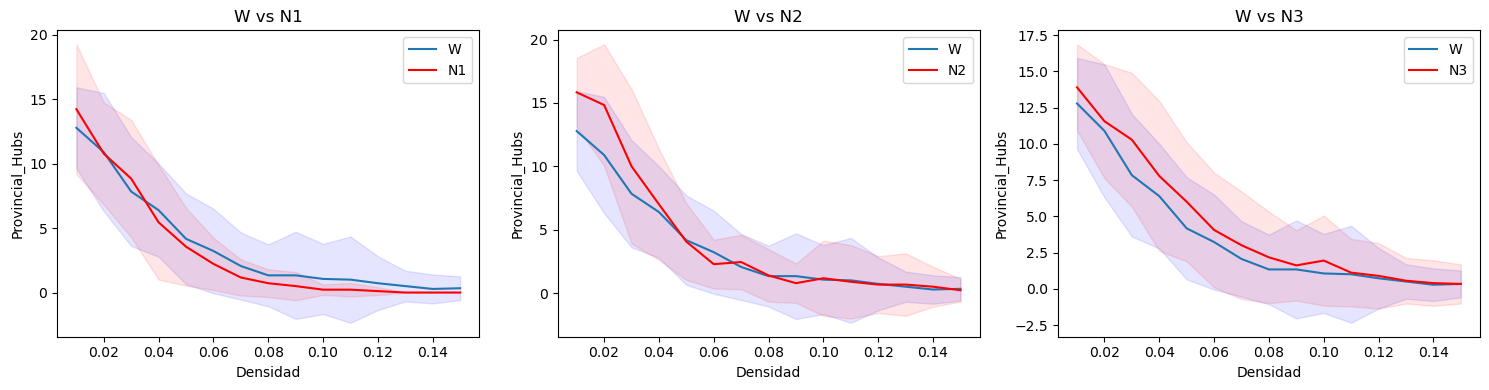

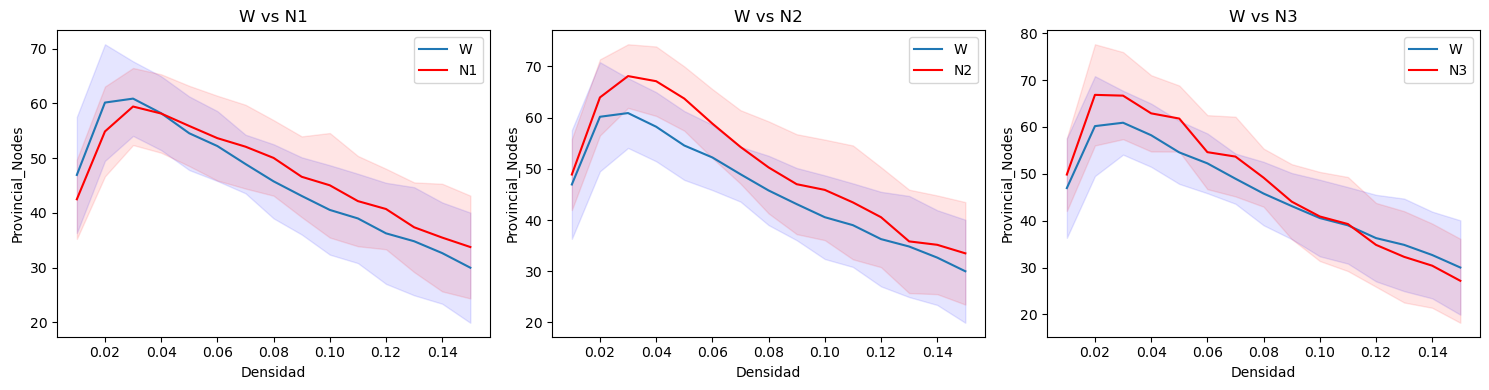

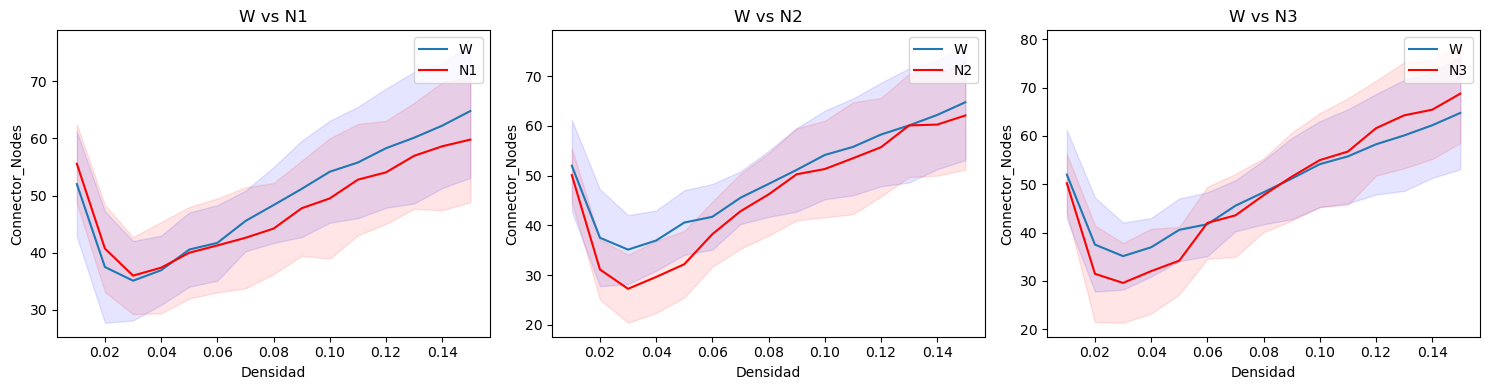

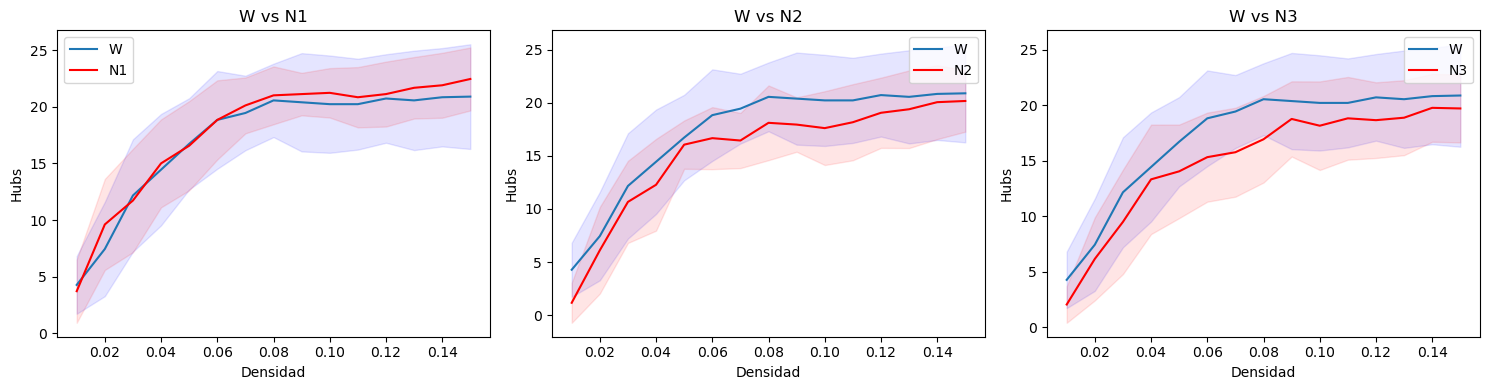

In [12]:
comparaciones = [('W','N1'),('W','N2'),('W','N3')]
plot_experimental_comparison(comparations=comparaciones,
                             densities=densities,
                             averages=Phubs_avg,
                             std_errors=Phubs_CI,
                             name='Provincial_Hubs')

plot_experimental_comparison(comparations=comparaciones,
                             densities=densities,
                             averages=Pnodes_avg,
                             std_errors=Pnodes_CI,
                             name='Provincial_Nodes')

plot_experimental_comparison(comparations=comparaciones,
                             densities=densities,
                             averages=Cnodes_avg,
                             std_errors=Cnodes_CI,
                             name='Connector_Nodes')

plot_experimental_comparison(comparations=comparaciones,
                             densities=densities,
                             averages=Hubs_avg,
                             std_errors=Hubs_CI,
                             name='Hubs')

In [13]:
# Test suite

print('RUNNING TESTS FOR PROVINCIAL_HUBS, COMPARING WITH AWAKE W')
run_t_tests_with_FDR(Phubs, compare_with='W')
print()
print('###################################################################')
print()
print('RUNNING TESTS FOR PROVINCIAL_NODES, COMPARING WITH AWAKE W')
run_t_tests_with_FDR(Pnodes, compare_with='W')
print()
print('###################################################################')
print()
print('RUNNING TESTS FOR CONNECTOR_NODES, COMPARING WITH AWAKE W')
run_t_tests_with_FDR(Cnodes, compare_with='W')
print()
print('###################################################################')
print()
print('RUNNING TESTS FOR HUBS, COMPARING WITH AWAKE W')
run_t_tests_with_FDR(Hubs, compare_with='W')
print()

RUNNING TESTS FOR PROVINCIAL_HUBS, COMPARING WITH AWAKE W
Density Value: 0.01
N1: Ttest_indResult(statistic=0.9833689405514752, pvalue=0.3337005839247631) 
Density Value: 0.019999999999999997
N1: Ttest_indResult(statistic=-0.07405316311773519, pvalue=0.9414109252711891) 
Density Value: 0.03
N1: Ttest_indResult(statistic=0.6505663029413854, pvalue=0.5197231705858817) 
Density Value: 0.039999999999999994
N1: Ttest_indResult(statistic=-0.6663427440198535, pvalue=0.5098768409308753) 
Density Value: 0.049999999999999996
N1: Ttest_indResult(statistic=-0.532547447088025, pvalue=0.5978921559940833) 
Density Value: 0.05999999999999999
N1: Ttest_indResult(statistic=-1.0487326902462104, pvalue=0.3031550533462568) 
Density Value: 0.06999999999999999
N1: Ttest_indResult(statistic=-1.216250716577153, pvalue=0.23480420073044245) 
Density Value: 0.07999999999999999
N1: Ttest_indResult(statistic=-0.9389874255498648, pvalue=0.3572722594657878) 
Density Value: 0.08999999999999998
N1: Ttest_indResult(stat

In [16]:
def parse_hubs(data: Dict[str, Iterable[float]], estadio: str):
    zi_mask = node_info[estadio]['zi'] > ZC
    Pi_mask = node_info[estadio]['Pi'] > PC
    Phub_mask = zi_mask & ~Pi_mask
    Hub_mask = zi_mask & Pi_mask
    Cnode_mask = ~zi_mask & Pi_mask
    Pnode_mask = ~zi_mask & ~Pi_mask
    return {
        'Provincial_Hubs': [i for i, flag in enumerate(Phub_mask) if flag],
        'Hubs': [i for i, flag in enumerate(Hub_mask) if flag],
        'Connector_Nodes': [i for i, flag in enumerate(Cnode_mask) if flag],
        'Provincial_Nodes': [i for i, flag in enumerate(Pnode_mask) if flag],
    }

In [15]:
%%time

RegionsNames = pd.read_csv("aal_extended_withCoords.csv", header=None).iloc[:,1:]

# density = 0.03
avg_graph = {key: graph_factory(G, 0.03) for key, G in avg_graphs[2].items()}
node_info = {estadio: run_node_experiment(avg_graph[estadio]) for estadio in ESTADIOS}
node_classes = {estadio: parse_hubs(node_info, estadio) for estadio in ESTADIOS}

CPU times: total: 62.5 ms
Wall time: 43 ms


In [28]:
def plot_brain_graph(avg_graphs: Dict[str, nx.Graph], 
                     node_classes: Dict[str, Dict[str, List[int]]], 
                     estadio: str) -> None:
    G = avg_graphs[estadio]
    comm_color = [-1 for i in range(ADJ_MATRIX_SIZE)]
    for label, node_list in node_classes[estadio].items():
        for node in node_list:
            if label=='Provincial_Hubs':
                comm_color[node] = 3
            elif label=='Hubs':
                comm_color[node] = 6
    nodes = G.nodes()
    plt.figure(figsize=(9,6))
    plt.title('Con nodos coloreados de acuerdo a su grado', fontsize=14)
    layout=dict(zip(range(ADJ_MATRIX_SIZE),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))
    vmin = min(comm_color)
    vmax = max(comm_color)
    cmap=plt.cm.Blues
    nx.draw(G, layout, node_size=20, node_color=comm_color, vmin=vmin, vmax=vmax,cmap=cmap)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    plt.colorbar(sm)

C:\Users\USER\AppData\Local\Temp\ipykernel_6628\1879711688.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


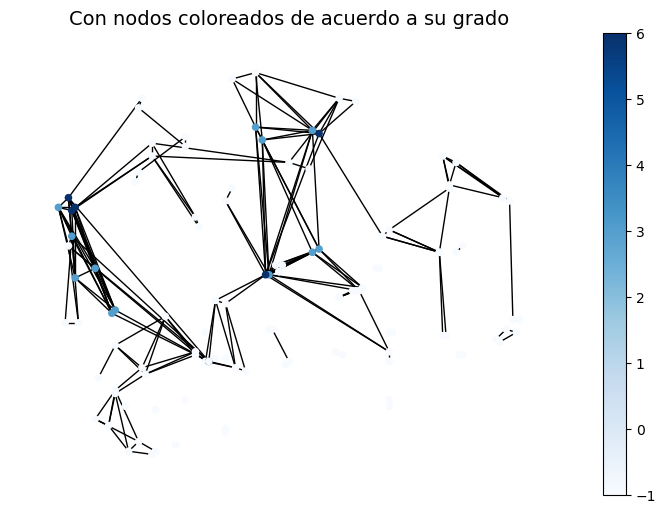

In [29]:
plot_brain_graph(avg_graph, node_classes, 'W')

C:\Users\USER\AppData\Local\Temp\ipykernel_6628\1879711688.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


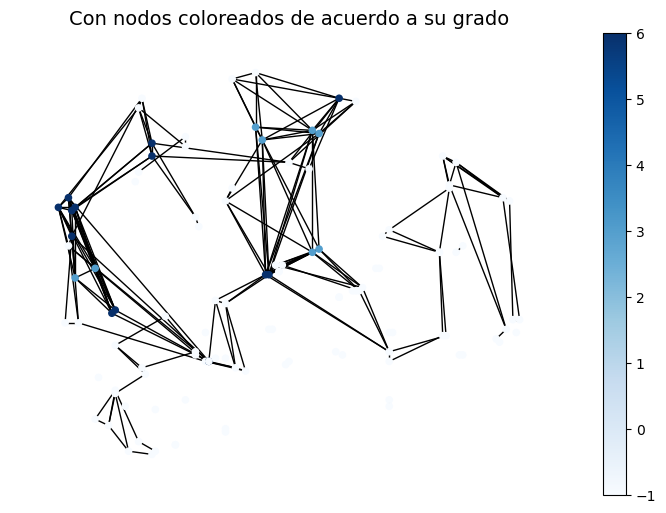

In [30]:
plot_brain_graph(avg_graph, node_classes, 'N1')

C:\Users\USER\AppData\Local\Temp\ipykernel_6628\1879711688.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


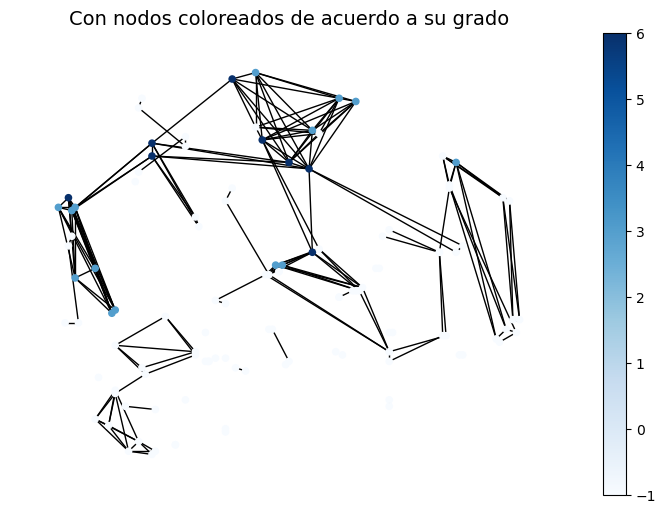

In [31]:
plot_brain_graph(avg_graph, node_classes, 'N2')

C:\Users\USER\AppData\Local\Temp\ipykernel_6628\1879711688.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


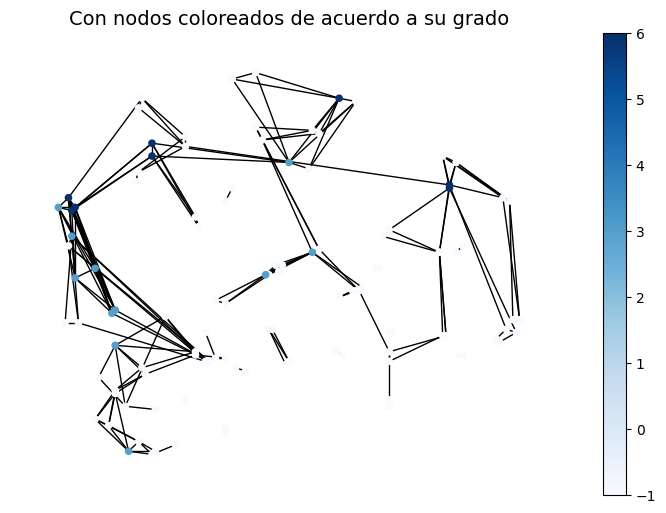

In [32]:
plot_brain_graph(avg_graph, node_classes, 'N3')